In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import struct
from sklearn.metrics import ConfusionMatrixDisplay

# Code taken from HW3_Helper.ipynb code posted by the TA 

# Load the MNIST data
def load_mnist_data():
    # Code from HW3_Helper.ipynb
    with open('/Users/dharineeshsomisetty/Downloads/data/train-images.idx3-ubyte','rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        nrows, ncols = struct.unpack(">II", f.read(8))
        data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        Xtraindata = np.transpose(data.reshape((size, nrows*ncols)))

    with open('/Users/dharineeshsomisetty/Downloads/data/train-labels.idx1-ubyte','rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        ytrainlabels = data.reshape((size,))

    with open('/Users/dharineeshsomisetty/Downloads/data/t10k-images.idx3-ubyte','rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        nrows, ncols = struct.unpack(">II", f.read(8))
        data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        Xtestdata = np.transpose(data.reshape((size, nrows*ncols)))

    with open('/Users/dharineeshsomisetty/Downloads/data/t10k-labels.idx1-ubyte','rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        ytestlabels = data.reshape((size,))
        
    return Xtraindata, ytrainlabels, Xtestdata, ytestlabels

# Load the data
Xtrain, ytrain, Xtest, ytest = load_mnist_data()

In [2]:

print(Xtrain.shape)
print(ytrain.shape)
print(Xtest.shape)
print(ytest.shape)


(784, 60000)
(60000,)
(784, 10000)
(10000,)


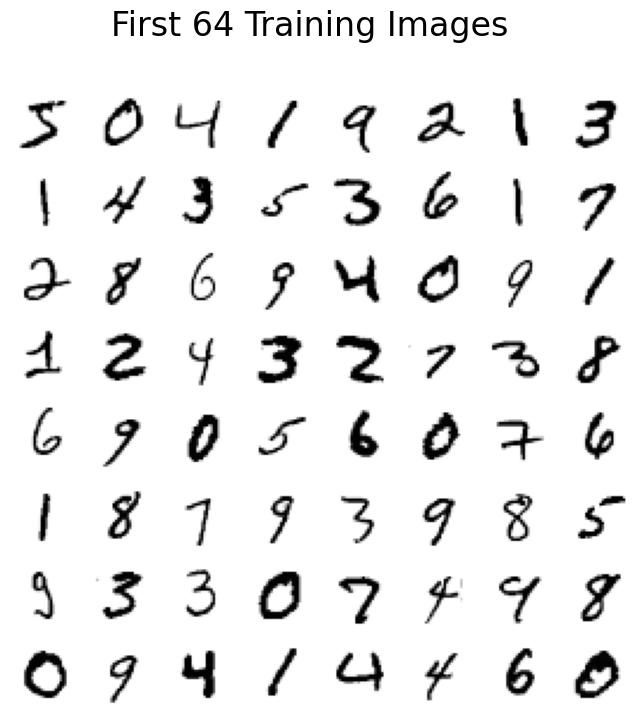

In [3]:
def plot_digits(XX, N, title):
    fig, ax = plt.subplots(N, N, figsize=(8, 8))
    
    for i in range(N):
      for j in range(N):
        ax[i,j].imshow(XX[:,(N)*i+j].reshape((28, 28)), cmap="Greys")
        ax[i,j].axis("off")
    fig.suptitle(title, fontsize=24)

plot_digits(Xtrain, 8, "First 64 Training Images" )


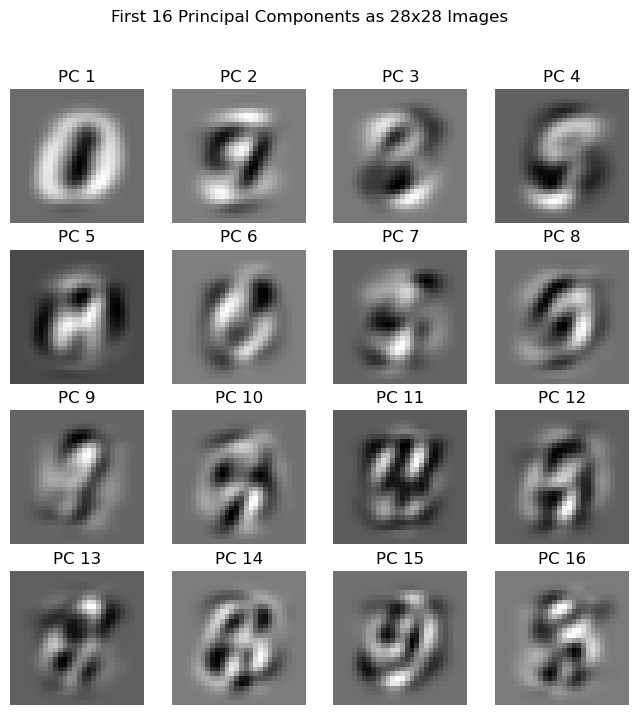

In [4]:
pca_all = PCA()
pca_all.fit(Xtrain.T)  # Fit on the entire training set

# (a) Plot the first 16 PC modes as 28x28 images
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    pc_reshaped = pca_all.components_[i].reshape(28, 28)
    ax.imshow(pc_reshaped, cmap='gray')
    ax.set_title(f'PC {i+1}')
    ax.axis('off')
plt.suptitle("First 16 Principal Components as 28x28 Images")
plt.show()

Number of components k for >=85% variance: 59


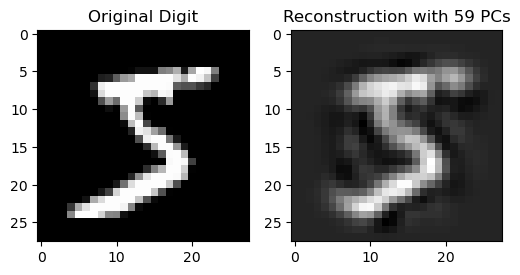

In [5]:

# Task 2: Inspect Cumulative Energy, find k for 85%

cumulative_variance = np.cumsum(pca_all.explained_variance_ratio_)
k_85 = np.argmax(cumulative_variance >= 0.85) + 1
print(f"Number of components k for >=85% variance: {k_85}")

# (Optional) Reconstruct a digit to confirm truncated images are reasonable
def reconstruct_digit(original, pca_model, n_components):
    # project
    X_proj = pca_model.transform(original.reshape(1, -1))[:, :n_components]
    # back-project
    reconstruction = pca_model.inverse_transform(
        np.hstack((X_proj, np.zeros((1, pca_model.n_components_ - n_components))))
    )
    return reconstruction.reshape(28, 28)

# Example: Reconstruct the first training sample using k_85
sample_digit = Xtrain.T[0]  # e.g., an image
reconstructed_85 = reconstruct_digit(sample_digit, pca_all, k_85)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
ax1.imshow(sample_digit.reshape(28, 28), cmap='gray')
ax1.set_title("Original Digit")
ax2.imshow(reconstructed_85, cmap='gray')
ax2.set_title(f"Reconstruction with {k_85} PCs")
plt.show()


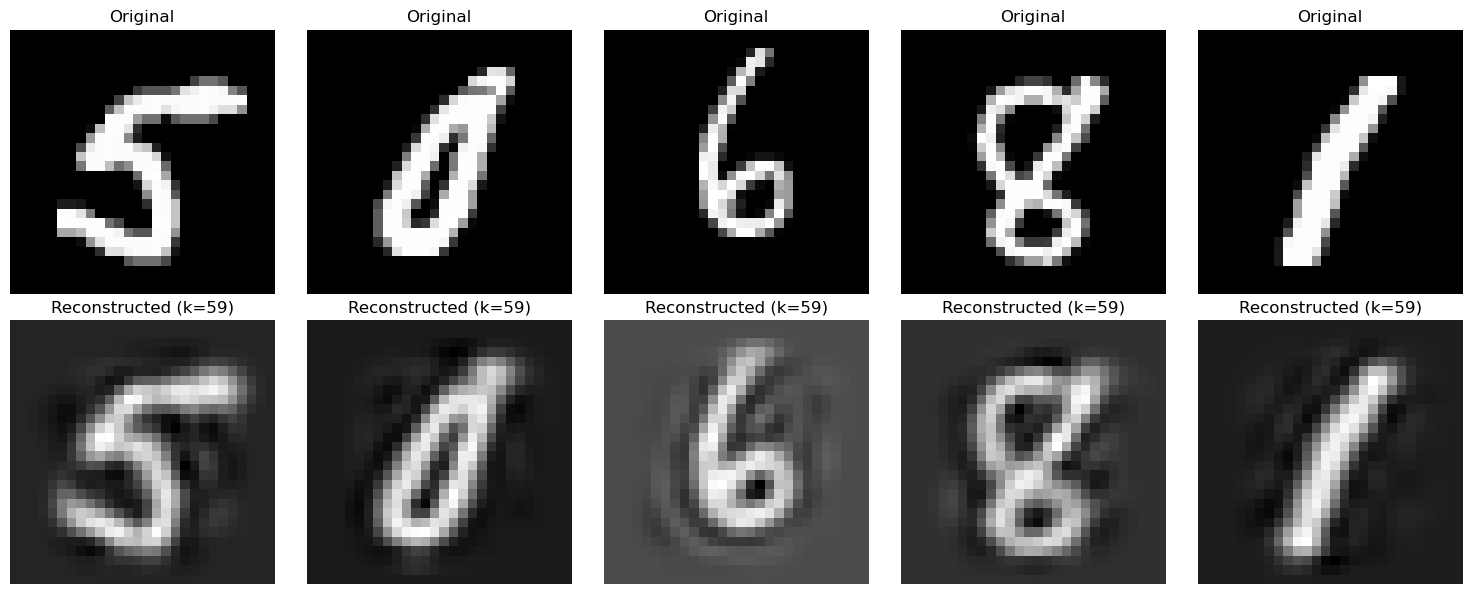

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def reconstruct_multiple_digits(X, pca, n_components=59, num_samples=5):
    """
    Reconstruct multiple digits from truncated PCA components.

    Parameters:
    -----------
    X              : (n_samples, 784) MNIST images flattened to 784 pixels
    pca            : Trained PCA object (sklearn.decomposition.PCA)
    n_components   : Number of components used for truncated reconstruction
    num_samples    : How many digits to reconstruct
    """

    # Randomly pick 'num_samples' indices
    indices = np.random.choice(X.shape[0], size=num_samples, replace=False)
    
    # Create a figure with 2 rows and 'num_samples' columns
    fig, axes = plt.subplots(nrows=2, ncols=num_samples, figsize=(3 * num_samples, 6))
    
    for i, idx in enumerate(indices):
        # Original image
        original_img = X[idx].reshape(28, 28)
        
        # 1) Transform the image into PCA space
        coords_full = pca.transform(original_img.reshape(1, -1))
        
        # 2) Truncate to 'n_components'
        coords_trunc = np.zeros(coords_full.shape)
        coords_trunc[:, :n_components] = coords_full[:, :n_components]
        
        # 3) Inverse transform to get reconstructed image
        reconstructed_img = pca.inverse_transform(coords_trunc)
        reconstructed_img = reconstructed_img.reshape(28, 28)
        
        # Plot original
        axes[0, i].imshow(original_img, cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')
        
        # Plot reconstructed
        axes[1, i].imshow(reconstructed_img, cmap='gray')
        axes[1, i].set_title(f"Reconstructed (k={n_components})")
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage (assuming you have X_train and a fitted PCA model):
reconstruct_multiple_digits(Xtrain.T, pca_all, n_components=59, num_samples=5)

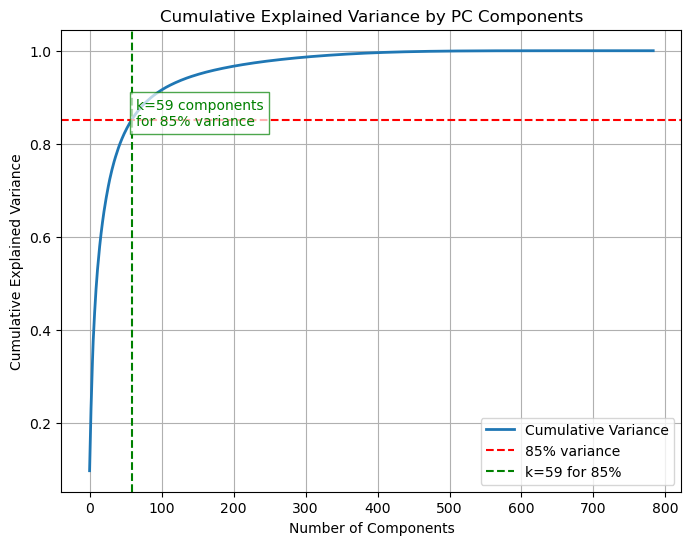

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Suppose k_85 is the result of np.argmax(cumulative_variance >= 0.85) + 1
# cumulative_variance is shape (n_components,), containing cumsum of explained_variance_ratio_

plt.figure(figsize=(8, 6))
plt.plot(cumulative_variance, linewidth=2, label='Cumulative Variance')

# Mark the 85% variance line (horizontal)
plt.axhline(y=0.85, color='r', linestyle='--', label='85% variance')

# Mark the k_85 vertical line
plt.axvline(x=k_85, color='g', linestyle='--', label=f'k={k_85} for 85%')

# Label, title, legends
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PC Components')
plt.legend()
plt.grid(True)

# Annotate the text near the line
plt.text(k_85 + 5, 0.84, f'k={k_85} components\nfor 85% variance', 
         color='green', 
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='green'))

plt.show()

In [8]:
#----------------------------------
# Task 3: Subset function for digits
#----------------------------------
def select_digits(X, y, digits):
    """Return X_sub, y_sub that contain only the specified digits."""
    mask = np.isin(y, digits)
    return X[mask], y[mask]

---- Task 4: Digits (1,8) ----
Digits 1 vs 8, (k=59) CV Accuracy: 0.9635 (+/- 0.0027)
Digits 1 vs 8, (k=59) Test Accuracy: 0.9796


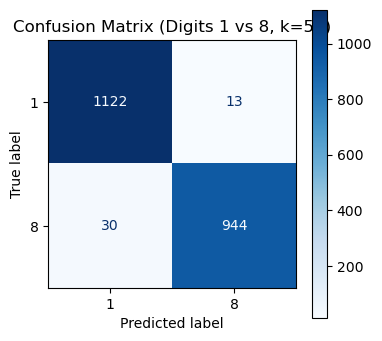

---- Task 5: Digits (3,8) ----
Digits 3 vs 8, (k=59) CV Accuracy: 0.9592 (+/- 0.0059)
Digits 3 vs 8, (k=59) Test Accuracy: 0.9637


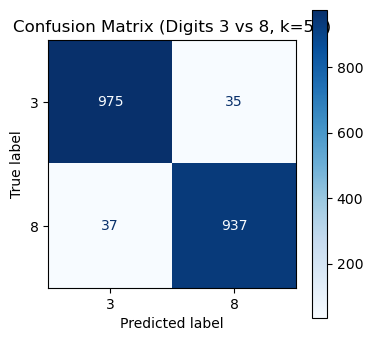

---- Task 5: Digits (2,7) ----
Digits 2 vs 7, (k=59) CV Accuracy: 0.9808 (+/- 0.0023)
Digits 2 vs 7, (k=59) Test Accuracy: 0.9728


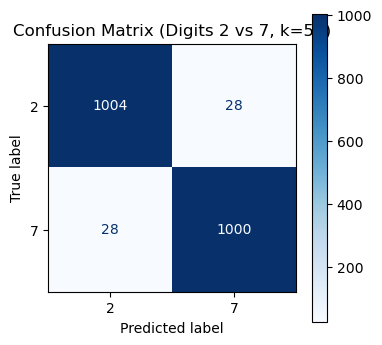

In [9]:
#----------------------------------
# Task 4 & 5: Classification of digit pairs
#----------------------------------
def classify_digit_pair(d1, d2, X_train, y_train, X_test, y_test, n_components):
    """Train a Ridge classifier on digits d1, d2 using n_components PCA and cross-validation."""
    # 1. Subset
    X_train_sub, y_train_sub = select_digits(X_train, y_train, [d1, d2])
    X_test_sub, y_test_sub = select_digits(X_test, y_test, [d1, d2])

    # 2. PCA
    pca_k = PCA(n_components=n_components)
    X_train_sub_pca = pca_k.fit_transform(X_train_sub)
    X_test_sub_pca  = pca_k.transform(X_test_sub)

    # 3. Train a Ridge classifier
    clf = RidgeClassifier()
    clf.fit(X_train_sub_pca, y_train_sub)

    # 4. Cross-validation on train subset
    scores = cross_val_score(clf, X_train_sub_pca, y_train_sub, cv=5)
    print(f"Digits {d1} vs {d2}, (k={n_components}) CV Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")

    # 5. Test Accuracy
    y_pred = clf.predict(X_test_sub_pca)
    test_acc = accuracy_score(y_test_sub, y_pred)
    print(f"Digits {d1} vs {d2}, (k={n_components}) Test Accuracy: {test_acc:.4f}")

    # 6. Confusion Matrix
    fig, ax = plt.subplots(figsize=(4, 4))
    disp = ConfusionMatrixDisplay.from_predictions(y_test_sub, y_pred, ax=ax, cmap='Blues')
    ax.set_title(f"Confusion Matrix (Digits {d1} vs {d2}, k={n_components})")
    plt.show()

# Example usage for digits (1,8)
print("---- Task 4: Digits (1,8) ----")
classify_digit_pair(1, 8, Xtrain.T, ytrain.T, Xtest.T, ytest.T, k_85)

print("---- Task 5: Digits (3,8) ----")
classify_digit_pair(3, 8, Xtrain.T, ytrain.T, Xtest.T, ytest.T, k_85)

print("---- Task 5: Digits (2,7) ----")
classify_digit_pair(2, 7, Xtrain.T, ytrain.T, Xtest.T, ytest.T, k_85)

In [10]:
#----------------------------------
# Task 6: Multi-class classification using entire dataset
#----------------------------------
# We'll do PCA with k_85, then compare Ridge, KNN, LDA
n_components_multi = k_85

pca_multi = PCA(n_components=n_components_multi)
X_train_multi_pca = pca_multi.fit_transform(Xtrain.T)
X_test_multi_pca  = pca_multi.transform(Xtest.T)

classifiers = {
    'Ridge': RidgeClassifier(),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'LDA': LinearDiscriminantAnalysis()
}

for name, clf in classifiers.items():
    clf.fit(X_train_multi_pca, ytrain.T)
    y_pred_train = clf.predict(X_train_multi_pca)
    y_pred_test  = clf.predict(X_test_multi_pca)

    train_acc = accuracy_score(ytrain.T, y_pred_train)
    test_acc  = accuracy_score(ytest.T,  y_pred_test)

    print(f"{name} Classifier [k={n_components_multi}] => Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")


Ridge Classifier [k=59] => Train Accuracy: 0.8454, Test Accuracy: 0.8561
KNN Classifier [k=59] => Train Accuracy: 0.9855, Test Accuracy: 0.9760
LDA Classifier [k=59] => Train Accuracy: 0.8665, Test Accuracy: 0.8753


In [11]:
#----------------------------------
# Task 7 (Bonus): Alternative Classifier (SVM)
#----------------------------------
from sklearn.svm import SVC
svm_clf = SVC(kernel='rbf', C=1.0)
svm_clf.fit(X_train_multi_pca, ytrain.T)
y_pred_test_svm = svm_clf.predict(X_test_multi_pca)
svm_acc_test = accuracy_score(ytest.T, y_pred_test_svm)
print(f"SVM (RBF) [k={n_components_multi}] => Test Accuracy: {svm_acc_test:.4f}")

y_train_pred = svm_clf.predict(X_train_multi_pca)
train_accuracy = accuracy_score(ytrain.T, y_train_pred)
print(f"SVM Training Accuracy: {train_accuracy:.2f}")

SVM (RBF) [k=59] => Test Accuracy: 0.9841
SVM Training Accuracy: 0.99
